In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nbeats_keras.model import NBeatsNet as NBeatsKeras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import custom_object_scope

#from nbeats_pytorch.model import NBeatsNet as NBeatsPytorch
from keras.optimizers import RMSprop, Adam
import time
from keras.models import load_model
#from target_data_electronic70_7 import target_X, target_y ,test_X, test_y
#from m4databasis21_7 import base_domain,zt_in,zt_out,M4Meta,inputsize,train_12,train_12_y
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from tensorflow.keras.losses import Loss
import tensorflow as tf
#from m4databasis35_7_70_7 import train_35,train_35_y,train_70,train_70_y
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, Add, Concatenate,Flatten,Reshape
#import pandas as pd
#####################################################################################
X_train = pd.read_csv("../data/M4_train.csv").iloc[:,(1):].values 
y_train = pd.read_csv("../data/M4_test.csv").iloc[:,1:].values
X_train.shape[1], y_train.shape[1]
target_X= pd.read_csv("../data/ele_train_input_7.csv").iloc[:,1:].values.astype(np.float32)/10000
target_y =pd.read_csv("../data/ele_train_output_7.csv").iloc[:,1:].values.astype(np.float32)/10000
test_X= pd.read_csv("../data/ele_val_input_7.csv").iloc[:,1:].values.astype(np.float32)/10000
test_y =pd.read_csv("../data/ele_val_output_7.csv").iloc[:,1:].values.astype(np.float32)/10000

target_X.shape,test_X.shape


#################################################################################
# loss SMAPE
class SMAPE(Loss):
    def call(self, y_true, y_pred):
        y_pred = tf.reshape(y_pred, tf.shape(y_true))  # 예측 값의 차원을 맞춤
       # y_pred=tf.clip_by_value(y_pred, 1e-10, tf.reduce_max(y_pred))
       # y_true = tf.clip_by_value(y_true, 1e-10, tf.reduce_max(y_true))
        
        numerator = 100 * tf.abs(y_true- y_pred )
        denominator =  (tf.abs(y_true ) + tf.abs(y_pred))/2
        smape =  numerator /  denominator #tf.clip_by_value(denominator, 1e-10, tf.reduce_max(denominator))
        return tf.reduce_mean(smape)

#################################################################################
# loss MASE
class MASE(Loss):
    def __init__(self, training_data, period, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.scale = self.calculate_scale(training_data, period)
    def seasonal_diff(data, period):
        return data[period:] - data[:-period]

    def calculate_scale(self, training_data, period):
        # 주기 차분 계산
        diff = seasonal_diff(training_data, period)
        scale = np.mean(np.abs(diff))
        return scale
    
    def call(self, y_true, y_pred):
        y_pred = tf.reshape(y_pred, tf.shape(y_true))  # 차원 맞추기
        error = tf.abs(y_true - y_pred)
        return tf.reduce_mean(error / self.scale)

def seasonal_diff(data, period):
    return data[period:] - data[:-period]


#################################################################################
#################################################################################
# 하이퍼파라미터 인자 설정
def hyperparameter():
    # 1 backcast
    # 2 forecast
    # 3 inputdim
    # 4 outputdim
    # 5 unit
    # 6 bacth size
    return X_train.shape[1], y_train.shape[1],1,1,128

#################################################################################
# nbeats + I모델 생성 함수
def bulid_model(backcast_,forecast_,input_dim,output_dim,unit):
    model= NBeatsKeras(backcast_length=backcast_, 
                       forecast_length=forecast_,
                       input_dim=input_dim,
                       output_dim=output_dim,
                       stack_types=(NBeatsKeras.TREND_BLOCK,
                                    NBeatsKeras.TREND_BLOCK,
                                    NBeatsKeras.TREND_BLOCK,
                                    NBeatsKeras.SEASONALITY_BLOCK,
                                    NBeatsKeras.SEASONALITY_BLOCK,
                                    NBeatsKeras.SEASONALITY_BLOCK)
                   ,nb_blocks_per_stack=1, thetas_dim=(1,2,2,4,4,4),
                   share_weights_in_stack=True, hidden_layer_units=unit)
    return model 
#################################################################################
# nbeats + G모델 생성 함수    
def bulid_model_G(backcast_,forecast_,input_dim,output_dim,unit):
    model= NBeatsKeras(backcast_length=backcast_, 
                       forecast_length=forecast_,
                       input_dim=input_dim,
                       output_dim=output_dim,
                       stack_types=(NBeatsKeras.GENERIC_BLOCK,NBeatsKeras.GENERIC_BLOCK)
                   ,nb_blocks_per_stack=5, thetas_dim=(4,4),
                   share_weights_in_stack=False, hidden_layer_units=unit)
    return model 
#################################################################################
# nbeats + I모델 부트스트랩 샘플링 배깅
import os

def train_bagging_models(num_models, loss_fn, epochs_, patience_, batch_size_, lr, save_path='./models/'):
    models = {}
    backcast, forecast, in_dim, out_dim, unit = hyperparameter()
    historys = []
    
    # 모델을 저장할 경로를 설정 (필요한 경우 저장 경로를 만듦)
    os.makedirs(save_path, exist_ok=True)
    
    for n in range(num_models):
        K.clear_session()
        model = bulid_model(backcast, forecast, in_dim, out_dim, unit)
        optimizer = Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss=loss_fn)
        
        # 부트스트랩 샘플링
        select = np.random.choice(len(X_train), size=len(X_train), replace=True)
        X_bootstrap = X_train[select]
        y_bootstrap = y_train[select]
        
        early_stop = EarlyStopping(monitor='val_loss', patience=patience_, verbose=0, restore_best_weights=True)
        history = model.fit(X_bootstrap, y_bootstrap, batch_size=batch_size_,
                            epochs=epochs_, verbose=0, 
                            callbacks=[early_stop],
                            validation_split=0.2)
        
        # 모델 저장 경로 지정 및 모델 저장
        model_save_path = os.path.join(save_path, f'{loss_fn}_model_{n+1}.h5')
        model.save(model_save_path)
        print(f'Model {n+1} saved at {model_save_path}')
        
        models[f'model_{n+1}'] = model
        historys.append(history)
        print(f'######################################################## Model {n+1}')
    
    return models, historys
#################################################################################
# nbeats + I모델 부트스트랩 샘플링 배깅

import os

def train_bagging_models_G(name,num_models, loss_fn, epochs_, patience_, batch_size_, lr, save_path='mape_models_G/'):
    models = {}
    backcast, forecast, in_dim, out_dim, unit = hyperparameter()
    historys = []
    
    # 모델을 저장할 경로를 설정 (필요한 경우 저장 경로를 만듦)
    os.makedirs(save_path, exist_ok=True)
    
    for n in range(num_models):
        K.clear_session()
        model = bulid_model_G(backcast, forecast, in_dim, out_dim, unit)
        optimizer = Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss=loss_fn)
        
        # 부트스트랩 샘플링
        select = np.random.choice(len(X_train), size=len(X_train), replace=True)
        X_bootstrap = X_train[select]
        y_bootstrap = y_train[select]
        
        early_stop = EarlyStopping(monitor='val_loss', patience=patience_, restore_best_weights=True)
        history = model.fit(X_bootstrap, y_bootstrap, batch_size=batch_size_,
                            epochs=epochs_, verbose=0, 
                            callbacks=[early_stop],
                            validation_split=0.2)
        
        # 모델 저장 경로 지정 및 모델 저장
        model_save_path = os.path.join(save_path, f'{name}_model_G_{n+1}.h5')
        model.save(model_save_path)
        print(f'Model {n+1} saved at {model_save_path}')
        
        models[f'model_{n+1}'] = model
        historys.append(history)
        print(f'######################################################## Model {n+1}')
    
    return models, historys

#################################################################################
##########################################################################################
# 트랜스퍼 레이어
class PositionalEncoding(layers.Layer):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = layers.Dropout(rate=dropout)

        position = np.arange(max_len)[:, np.newaxis]
        div_term = np.exp(np.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe = np.zeros((max_len, d_model))
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        pe = pe[np.newaxis, ...]

        self.pe = tf.constant(pe, dtype=tf.float32)

    def call(self, x):
        x = x + self.pe[:, :tf.shape(x)[1], :]
        return self.dropout(x)
##########################################################################################
# 트랜스퍼 레이어
def create_model(fn,d_model, nlayers, nhead, dropout, iw, ow,lr,pretrained_output_reshaped,inputs):
    
    
    x = layers.Dense(d_model // 2, activation='relu')(pretrained_output_reshaped)
    x = layers.Dense(d_model, activation='relu')(x)
    
    pos_encoding = PositionalEncoding(d_model, dropout)
    x = pos_encoding(x)
    
    for _ in range(nlayers):
        attn_output = layers.MultiHeadAttention(num_heads=nhead, key_dim=d_model, dropout=dropout)(x, x)
        x = layers.LayerNormalization(epsilon=1e-6)(x + attn_output)
        ffn_output = layers.Dense(d_model, activation='relu')(x)
        ffn_output = layers.Dense(d_model)(ffn_output)
        x = layers.LayerNormalization(epsilon=1e-6)(x + ffn_output)
    
    x = layers.Dense(d_model // 2, activation='relu')(x)
    x = layers.Dense(1)(x)
    x = tf.squeeze(x, axis=-1)
    
    outputs = layers.Dense((iw + ow) // 2, activation='relu')(x)
    outputs = layers.Dense(ow)(outputs)
    
    optimizer = Adam(learning_rate=lr)
    target_model = Model(inputs=inputs, outputs=outputs)
    target_model.compile(optimizer=optimizer, loss=fn)
    
    return target_model
########################################################################################################################
from keras.models import load_model

def transfer_(model_num, model_paths, trainable, lossf, epochs_, batch_size_, pt, lr_):
    history_mapes_G = []
    model_pred = []
    model_path = model_paths
    
    for i in range(1, model_num + 1):
        K.clear_session()
        
        with custom_object_scope({'SMAPE': SMAPE}):  # SMAPE 등록
            model1 = load_model(model_path + f'_model_G_{i}.h5')  # 저장된 모델 불러오기
        
        print(f"{model_path}_model_G_{i}.h5")
        
        # 모든 레이어를 학습 불가능하게 설정 (필요한 경우)
        for layer in model1.layers[:-1]:  # 마지막 레이어를 제외하고 학습 가능 여부 설정
            layer.trainable = trainable
        
        pretrained_layers = model1.layers[:-1]
        
        # 전이 학습을 위한 새로운 입력과 모델 구성
        pretrained_model = Model(inputs=model1.input, outputs=pretrained_layers[-1].output)
        inputs = Input(shape=(X_train.shape[1], 1))
        pretrained_output = pretrained_model(inputs)
        pretrained_output_reshaped = layers.Reshape((y_train.shape[1], -1))(pretrained_output)
        
        # 새로운 모델 생성 및 전이 학습
        model_instance = create_model(
            lossf, d_model=64, nlayers=1, nhead=1, dropout=0.1, iw=X_train.shape[1], 
            ow=y_train.shape[1], lr=lr_, pretrained_output_reshaped=pretrained_output_reshaped, inputs=inputs
        )
        
        early_stop = EarlyStopping(monitor='val_loss', patience=pt, verbose=0, restore_best_weights=True)
    
        history = model_instance.fit(
            target_X, target_y, batch_size=batch_size_, epochs=epochs_, verbose=0,
            callbacks=[early_stop], validation_split=0.2
        )
        
        pred = model_instance.predict(test_X)
        pred = pred.reshape(-1, y_train.shape[1])
        model_pred.append(pred)
        history_mapes_G.append(history)
        
        print(f"######################################################## fitted {i}")
    
    return model_pred
#################################################################################
# 예측

def bagging_predict(models, X):
    predictions = np.array([model.predict(X) for model in models.values()])
    return np.median(predictions, axis=0)

def bagging_predict2(models, X):
    predictions = np.array([model.predict(X) for model in models.values()])
    return predictions

In [6]:
#mape_models = train_bagging_models_G('mape',30,'mape',100,10,512,0.001)
smape_models = train_bagging_models_G('smape',30,SMAPE(),100,10,512,0.001,save_path='smape_models_G/')
#mase_models = train_bagging_models_G('mse',30,'mse',100,10,512,0.001,save_path='mse_models_G/')

2024-09-21 12:39:46.084741: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-09-21 12:39:46.084825: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ymlee2-desktop): /proc/driver/nvidia/version does not exist
2024-09-21 12:39:46.085470: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model 1 saved at smape_models_G/smape_model_G_1.h5
######################################################## Model 1
Model 2 saved at smape_models_G/smape_model_G_2.h5
######################################################## Model 2
Model 3 saved at smape_models_G/smape_model_G_3.h5
######################################################## Model 3
Model 4 saved at smape_models_G/smape_model_G_4.h5
######################################################## Model 4
Model 5 saved at smape_models_G/smape_model_G_5.h5
######################################################## Model 5
Model 6 saved at smape_models_G/smape_model_G_6.h5
######################################################## Model 6
Model 7 saved at smape_models_G/smape_model_G_7.h5
######################################################## Model 7
Model 8 saved at smape_models_G/smape_model_G_8.h5
######################################################## Model 8
Model 9 saved at smape_models_G/smape_model_G_9.h5
#####################

In [10]:
#mape_pred = transfer_(3,'models_G/mape',True, 'mape',5,8,30,0.00005)
#smase_pred = transfer_(30,'mse_models_G/mse',True, 'mse',1000,8,30,0.00003)
smape_pred = transfer_(30,'smape_models_G/smape',True, SMAPE(),1000,8,30,0.00005)

smape_models_G/smape_model_G_1.h5
12/12 [==============================] - 1s 6ms/step
######################################################## fitted 1
smape_models_G/smape_model_G_2.h5
12/12 [==============================] - 1s 6ms/step
######################################################## fitted 2
smape_models_G/smape_model_G_3.h5
12/12 [==============================] - 1s 5ms/step
######################################################## fitted 3
smape_models_G/smape_model_G_4.h5
12/12 [==============================] - 0s 4ms/step
######################################################## fitted 4
smape_models_G/smape_model_G_5.h5
12/12 [==============================] - 1s 6ms/step
######################################################## fitted 5
smape_models_G/smape_model_G_6.h5
12/12 [==============================] - 1s 8ms/step
######################################################## fitted 6
smape_models_G/smape_model_G_7.h5
12/12 [==============================] - 1s 6ms/

In [8]:
concat_G[15:][15:]

(15, 358, 24)

In [11]:
concat_G = np.concatenate([np.array(smape_pred)])

fin_pred_G = np.median(concat_G[:],axis=0)

mean_squared_error(test_y.flatten(),fin_pred_G.flatten()),mean_absolute_error(test_y.flatten(),fin_pred_G.flatten())

(0.086940855, 0.19614585)

In [61]:
concat_G = np.concatenate([np.array(smape_pred)[:10]])

fin_pred_G = np.median(concat_G[:],axis=0)

mean_squared_error(test_y.flatten(),fin_pred_G.flatten()),mean_absolute_error(test_y.flatten(),fin_pred_G.flatten())

(3.1442833, 0.6518182)

In [62]:
concat_G = np.concatenate([np.array(smape_pred)[:20]])

fin_pred_G = np.median(concat_G[:],axis=0)

mean_squared_error(test_y.flatten(),fin_pred_G.flatten()),mean_absolute_error(test_y.flatten(),fin_pred_G.flatten())

(0.750099, 0.3476573)

In [44]:
mselist = [mean_squared_error(test_y.flatten(),concat_G[i].flatten()) for i in range(30)]
mselist.index(np.min(mselist))

20

In [16]:
def transfer_1(model_num, model_paths,N, trainable, lossf, epochs_, batch_size_, pt, lr_):
    history_mapes_G = []
    model_pred = []
    model_path = model_paths
    for i in range(1, model_num + 1):
        K.clear_session()
        
        # 저장된 모델 경로에서 모델 불러오기
        #model_path = model_paths[i - 1]  # 각 모델의 경로를 리스트로 받아 처리
        #model_paths = model_path #+ f'_model_G_{i}.h5'
        with custom_object_scope({'SMAPE': SMAPE}):  # SMAPE 등록
            model1 = load_model(model_path+ f'_model_G_{N}.h5')  # 저장된 모델 불러오기
        print(f"{i}{model_path}_model_G_{N}.h5")
        
        # 모든 레이어를 학습 불가능하게 설정 (필요한 경우)
        for layer in model1.layers[:-1]:  # 마지막 레이어를 제외하고 학습 가능 여부 설정
            layer.trainable = trainable
        
        pretrained_layers = model1.layers[:-1]
        
        # 전이 학습을 위한 새로운 입력과 모델 구성
        pretrained_model = Model(inputs=model1.input, outputs=pretrained_layers[-1].output)
        inputs = Input(shape=(X_train.shape[1], 1))
        pretrained_output = pretrained_model(inputs)
        pretrained_output_reshaped = layers.Reshape((y_train.shape[1], -1))(pretrained_output)
        
        # 새로운 모델 생성 및 전이 학습
        model_instance = create_model(
            lossf, d_model=64, nlayers=1, nhead=1, dropout=0.1, iw=X_train.shape[1], 
            ow=y_train.shape[1], lr=lr_, pretrained_output_reshaped=pretrained_output_reshaped, inputs=inputs
        )
        
        early_stop = EarlyStopping(monitor='val_loss', patience=pt, verbose=0, restore_best_weights=True)
    
        history = model_instance.fit(
            target_X, target_y, batch_size=batch_size_, epochs=epochs_, verbose=0,
            callbacks=[early_stop], validation_split=0.2
        )
        
        pred = model_instance.predict(test_X)
        pred = pred.reshape(-1, y_train.shape[1])
        model_pred.append(pred)
        history_mapes_G.append(history)
        
        print(f"######################################################## fitted {i}")
    
    return model_pred, history_mapes_G

In [45]:
mape_pred2 = transfer_1(30,'smape_models_G/smape',20,True, SMAPE(),1000,8,30,0.00005)

1smape_models_G/smape_model_G_20.h5
12/12 [==============================] - 1s 6ms/step
######################################################## fitted 1
2smape_models_G/smape_model_G_20.h5
12/12 [==============================] - 1s 8ms/step
######################################################## fitted 2
3smape_models_G/smape_model_G_20.h5
12/12 [==============================] - 1s 7ms/step
######################################################## fitted 3
4smape_models_G/smape_model_G_20.h5
12/12 [==============================] - 1s 8ms/step
######################################################## fitted 4
5smape_models_G/smape_model_G_20.h5
12/12 [==============================] - 1s 4ms/step
######################################################## fitted 5
6smape_models_G/smape_model_G_20.h5
12/12 [==============================] - 1s 7ms/step
######################################################## fitted 6
7smape_models_G/smape_model_G_20.h5
12/12 [===========================

In [46]:
concat_G2 = np.concatenate([np.array(mape_pred2[0])])

fin_pred_G2 = np.median(concat_G2[:],axis=0)

mean_squared_error(test_y.flatten(),fin_pred_G2.flatten()),mean_absolute_error(test_y.flatten(),fin_pred_G2.flatten())

(0.6439458, 0.34997216)

In [47]:
mselist2 = [mean_squared_error(test_y.flatten(),concat_G2[i].flatten()) for i in range(30)]


In [48]:
df = pd.DataFrame({'MSE':mselist,
             'min-MSE':mselist2})

df.describe()

,MSE,min-MSE
count,30.000000,30.000000
mean,39.137707,36.946884
std,13.888390,12.479402
min,12.293058,16.688480
25%,30.756649,28.182540
50%,37.316841,35.488983
75%,46.829015,42.692562
max,72.151421,70.781662


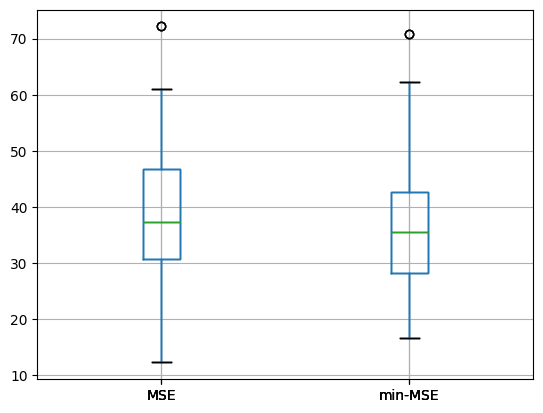

In [53]:
df.boxplot()
plt.show()

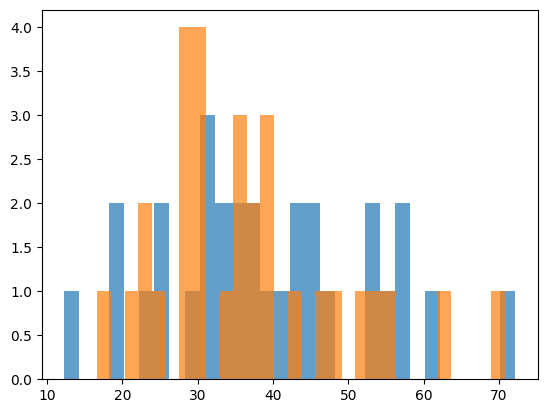

In [54]:
plt.hist(mselist,bins=30,alpha=0.7)
plt.hist(mselist2,bins=30,alpha=0.7)
plt.show()